In [48]:
%load_ext autoreload
%autoreload 2
%cd "python/LatentEvolution"
%ls

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Errno 2] No such file or directory: 'python/LatentEvolution'
/home/hew/python/LatentEvolution
cache/  data/  figure/  framework/  main.py  script/  temp/


In [49]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from scipy.stats import pearsonr
from sklearn.manifold import TSNE

from framework.utils.lightning.trainer_utils import LitInference
from script.task_02_ProteinVAE.ProteinVAE.sequence_data_module import SequenceDataModule
from script.task_02_ProteinVAE.ProteinVAE.sequence_lightning_module import SequenceLightningModule

In [7]:
log_dir = "./script/task_02_ProteinVAE/lightning_logs/"

# WAE
version = 2
epoch = '95, loss=35.447, ce=18.697, reg=10.702, mse=6.049, ddG=0.537, dS=0.861.ckpt'

In [8]:
inferencer = LitInference(SequenceLightningModule, SequenceDataModule, log_dir, version, epoch)
inferencer.set_batch_size(128)
tokenizer = inferencer.pl_data_module.tokenizer
model = inferencer.model.eval()
model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42


============================== PeptideDataModule __init__ Start ==============================
============================== PeptideDataModule __init__ End ==============================


ProteinVAE(
  (encoder_transformer): ESMTransformer(
    (embed_tokens): Embedding(33, 128, padding_idx=1)
    (layers): ModuleList(
      (0): TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (final_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)

In [9]:
def decode_latent_embeddings(z):
    logits = model.decode(z)[:, 1:-1]
    tokens = torch.argmax(logits, dim=-1)
    sequences = tokenizer.decode(tokens)
    return sequences

In [10]:
predictions = inferencer.predict('train_valid_test')
# predictions = inferencer.predict('test')

# seqs = [
#     'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDQWSAFLKEQSTIAQMYPLQEIKNLTVKLVLQALQ',
#     'STIELQAKDFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQHIQNTTVKLQLQALQ',
#     'STIEEQAKPFLDKFNHEAEDLFYQHSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
# ]
# predictions = inferencer.predict(seqs)

============================== prepare_data: mode[predict] Start ==============================
prepare_data predict_data kwargs {'predict_data': 'train_valid_test'}
============================== prepare_data: mode[train] Start ==============================
============================== prepare_dataset Start ==============================
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< load data according to selected index >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/2404 [00:00<?, ?it/s]

the dataset has not been partitioned, split dataset with specific ratio


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


dataframe partition values:
train    1661
test      521
valid     222
Name: partition, dtype: int64
select the subset for debug, max_len: 83, ratio: 1, number: 2404
============================== prepare_dataset End ==============================
len(self.train_dataset) 1661
len(self.valid_dataset) 222
len(self.test_dataset) 521
============================== prepare_data mode[train] End ==============================
len(self.predict_index) 2404
============================== prepare_data mode[predict] End ==============================
============================== Setup [test] Start ==============================
[len self.predict_dataset] 2404
============================== Setup [test] End ==============================


Predicting: 0it [00:00, ?it/s]

In [11]:
true_tokens = torch.concat([batch['tokens'] for batch in predictions])
recon_tokens = torch.concat([batch['recon_tokens'] for batch in predictions])
predict_z = torch.concat([batch['z'] for batch in predictions])
predict_mean = torch.concat([batch['mean'] for batch in predictions])
predict_logvar = torch.concat([batch['logvar'] for batch in predictions])

sample_z = predict_mean + torch.randn_like(predict_logvar) * torch.exp(0.5 * predict_logvar)

In [12]:
predict_mean[:5, 0], predict_logvar[:5, 0], predict_z[:5, 0], sample_z[:5, 0]

(tensor([ 2.9886,  3.0468, -0.7596,  0.1806,  2.6885]),
 tensor([ 0.3383,  0.6445,  0.7698, -3.9763, -3.3699]),
 tensor([ 2.9886,  3.0468, -0.7596,  0.1806,  2.6885]),
 tensor([ 3.7920e+00,  1.9083e+00, -7.7218e-01, -1.0984e-04,  2.8213e+00]))

In [13]:
sample_z, decode_latent_embeddings(sample_z[:5])


100%|██████████| 5/5 [00:00<00:00, 2855.21it/s]


(tensor([[ 3.7920,  1.4817,  4.7317,  ..., -3.5613,  1.0979, -0.4589],
         [ 1.9083,  2.4062,  3.9916,  ..., -3.9429,  1.8263, -1.0029],
         [-0.7722, -1.6532, -2.7766,  ...,  1.6731,  1.3613, -1.2212],
         ...,
         [-2.8722, -0.9210, -3.3340,  ..., -3.4317,  0.9841, -0.6545],
         [-0.0096, -2.7007,  1.1205,  ...,  3.5508, -2.1898,  2.7055],
         [ 2.8414,  6.3275,  7.3774,  ...,  5.3902, -2.8043,  3.2188]]),
 ['SSVVGQWQQFLDLFQQQLLVRWQQSAAAWWNKLLNQTIELNQNMNPFFDKQWLFLKQQSTLAQDSPLLLVVVLTVKLQQQLLA',
  'QTITEQSWKEDDLFNDENKKNDAQSLLASQHYNTNITEENNQNMNNNGGKQSLVLQQQQTDAQMTPLTQQQNEGVKLQLQRLQ',
  'QTPLEGNNPEDDKNNMHNDMGAHQSMLMWQNNMTNQEEENNQQQENLNEMPNLFLQEVPTLQQLTPLQEMVMMGVNMMLHNLQ',
  'QDPKMQMKQFLDKKPKDDHWERDLDNLASLMNNDLLHQENVQLMNNADLMMSDNLKMMSMLQQMDPLQDMKNKKVKMLQGDLV',
  'QSMEDQDTVHDDKDNHQQEDEHWQSTAAGNNLNTNITEENVQNWPNGGLKMDLFLAQQSTNQQMMPHLEDQPMDQKQMLQLLQ'])

In [14]:
predict_z, decode_latent_embeddings(predict_z[:5])


100%|██████████| 5/5 [00:00<00:00, 5939.26it/s]


(tensor([[ 2.9886,  2.1843,  4.7677,  ...,  1.0743,  1.0784, -0.3926],
         [ 3.0468,  2.2822,  4.1796,  ..., -0.0556,  1.9057, -1.1634],
         [-0.7596, -1.6696, -2.5221,  ...,  0.3137,  1.5269, -1.1824],
         ...,
         [-0.6623, -0.7953, -2.9437,  ...,  0.8251,  1.0718, -0.4423],
         [ 0.2954,  1.5969,  1.7897,  ...,  3.2345, -2.0918,  2.7352],
         [ 2.9921,  2.4696,  4.3977,  ...,  3.2583, -2.7719,  3.1373]]),
 ['STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAIDVWEAFLKEQSTLAQMYPLQEIQNLTVKLQLWALQ',
  'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ'])

In [15]:
predict_mean, decode_latent_embeddings(predict_mean[:5])


100%|██████████| 5/5 [00:00<00:00, 4888.47it/s]


(tensor([[ 2.9886,  2.1843,  4.7677,  ...,  1.0743,  1.0784, -0.3926],
         [ 3.0468,  2.2822,  4.1796,  ..., -0.0556,  1.9057, -1.1634],
         [-0.7596, -1.6696, -2.5221,  ...,  0.3137,  1.5269, -1.1824],
         ...,
         [-0.6623, -0.7953, -2.9437,  ...,  0.8251,  1.0718, -0.4423],
         [ 0.2954,  1.5969,  1.7897,  ...,  3.2345, -2.0918,  2.7352],
         [ 2.9921,  2.4696,  4.3977,  ...,  3.2583, -2.7719,  3.1373]]),
 ['STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAIDVWEAFLKEQSTLAQMYPLQEIQNLTVKLQLWALQ',
  'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ'])

In [16]:
recon_sequences = tokenizer.decode(recon_tokens[:5])
recon_sequences


100%|██████████| 5/5 [00:00<00:00, 2474.22it/s]


['STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAIDVWEAFLKEQSTLAQMYPLQEIQNLTVKLQLWALQ',
 'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ']

In [17]:
set(recon_sequences)

{'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ',
 'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAIDVWEAFLKEQSTLAQMYPLQEIQNLTVKLQLWALQ'}

In [18]:
true_sequences = tokenizer.decode(true_tokens[:5])
true_sequences


100%|██████████| 5/5 [00:00<00:00, 1931.43it/s]


['STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWLAFLKEQSTLAQMYPLEEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAIDVWEAFLKEQSTLAQMYPLQEIQNLTVKLQLWALQ',
 'STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNNARDKWSAFLKEQSTLAQMYPLQEIDNLTVKLQLQALQ',
 'SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGNAGDKWSAFLKEQSTLAQMYPLQEIQNLTPKLQLQALQ']

In [19]:
recon_sequences == decode_latent_embeddings(predict_z[:5])


100%|██████████| 5/5 [00:00<00:00, 2545.09it/s]


True

In [20]:
for seq1, seq2 in zip(recon_sequences, true_sequences):
    print(seq1 == seq2)

True
True
True
False
True


In [21]:
true_tokens[0]

tensor([ 8, 11, 12,  9,  9, 16,  5, 15, 11, 18,  4, 13, 15, 18, 17, 21,  9,  5,
         9, 13,  4, 18, 19, 16,  8,  8,  4,  5,  8, 22, 17, 19, 17, 11, 17, 12,
        11,  9,  9, 17,  7, 16, 17, 20, 17, 17,  5,  6, 13, 15, 22,  4,  5, 18,
         4, 15,  9, 16,  8, 11,  4,  5, 16, 20, 19, 14,  4,  9,  9, 12, 16, 17,
         4, 11,  7, 15,  4, 16,  4, 16,  5,  4, 16])

In [22]:
recon_tokens[0]

tensor([ 8, 11, 12,  9,  9, 16,  5, 15, 11, 18,  4, 13, 15, 18, 17, 21,  9,  5,
         9, 13,  4, 18, 19, 16,  8,  8,  4,  5,  8, 22, 17, 19, 17, 11, 17, 12,
        11,  9,  9, 17,  7, 16, 17, 20, 17, 17,  5,  6, 13, 15, 22,  4,  5, 18,
         4, 15,  9, 16,  8, 11,  4,  5, 16, 20, 19, 14,  4,  9,  9, 12, 16, 17,
         4, 11,  7, 15,  4, 16,  4, 16,  5,  4, 16])

In [23]:
sample_error_rate = torch.sum(~(true_tokens[0] == recon_tokens[0])) / len(true_tokens[0])
average_error_rate = torch.sum(~(true_tokens == recon_tokens)) / len(true_tokens[0]) / len(true_tokens)
average_error_num = average_error_rate * len(true_tokens[0])
sample_error_rate, average_error_rate, average_error_num, len(true_tokens)

(tensor(0.), tensor(0.0093), tensor(0.7708), 2404)

In [24]:
data_df = pd.read_csv('./data/ACE2_variants/cooked/ACE2_variants.csv')
data_df

,index,name,partition,length,sequence,structure,graph,ddG,dS
0,0,0,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,0.4875,0.000
1,1,1,NaN,83,STIELQAKDFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,1.6714,-0.063
2,10,10,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENIQNMNN...,NaN,NaN,-0.7219,0.000
3,100,100,NaN,83,STIEEQAKTFLDKFNFEAEDLFYQSSQASWNYNTNITEENVQNMNN...,NaN,NaN,3.1538,0.043
4,1000,1000,NaN,83,STWEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENDQNMNN...,NaN,NaN,3.6520,0.017
...,...,...,...,...,...,...,...,...,...
126207,99995,99995,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNP...,NaN,NaN,3.7586,0.000
126208,99996,99996,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,0.9857,0.017
126209,99997,99997,NaN,83,STNEEQAKTFLDKFNHEAEWLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,3.0270,-0.051
126210,99998,99998,NaN,83,SDMEEIAKTFLDKFNHEAEDLFYQSSLASWEYNTNITEENVKNMNN...,NaN,NaN,-2.9044,0.017


In [25]:
true_sequences = tokenizer.decode(true_tokens)
data_df = data_df[data_df['sequence'].isin(true_sequences)]
data_df


100%|██████████| 2404/2404 [00:00<00:00, 8178.19it/s]


,index,name,partition,length,sequence,structure,graph,ddG,dS
24,100017,100017,NaN,83,STIEEQAKKFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,-2.4635,0.017
25,100018,100018,NaN,83,SFIEEQAKTFLDKFNHEAEDLFYQSSLASWQYNTNITEENVQNMDN...,NaN,NaN,-0.0984,0.017
38,10003,10003,NaN,83,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMND...,NaN,NaN,-0.3993,0.017
129,100111,100111,NaN,83,STIEEQAKDFLDKFNHEAEDLFYQSGLASWNYNTNITEENFQNMNN...,NaN,NaN,-0.4204,0.017
147,100128,100128,NaN,83,STYEEQAKTFLDWFNHEAEDLFYQSSLASWNYNTNITEENVQDMNF...,NaN,NaN,-2.1772,0.017
...,...,...,...,...,...,...,...,...,...
126049,99852,99852,NaN,83,STIEEQANTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,-1.0496,0.017
126180,99970,99970,NaN,83,SYIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMMN...,NaN,NaN,-1.3314,0.017
126196,99985,99985,NaN,83,ETIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,NaN,-2.0284,0.017
126206,99994,99994,NaN,83,SAIEEQAKTFLDKFNHEAEDLFYQSSLANWNYNTNITEENVDNMNN...,NaN,NaN,-1.4916,0.017


In [26]:
prediction_data = {
    'true_tokens': true_tokens,
    'recon_tokens': recon_tokens,
    'predict_z': predict_z,
    'predict_mean': predict_mean,
    'predict_logvar': predict_logvar,
    'true_sequences': true_sequences,
    'ddG': data_df.ddG.to_numpy(),
    'dS': data_df.dS.to_numpy()
}

diffusion_model_train_data = {
    'mean': predict_mean,
    'z': predict_z,
    'ddG': data_df.ddG.to_numpy(),
    'dS': data_df.dS.to_numpy()
}

In [27]:
%%time
save_file = f'./script/task_03_Latent_analysis/version_{version}_prediction_data.pt'
if not os.path.exists(save_file):
    torch.save(prediction_data, save_file)

CPU times: user 17.5 ms, sys: 47.9 ms, total: 65.4 ms
Wall time: 64.7 ms


In [28]:
%%time
save_file = f'./script/task_04_LatentRegression/version_{version}_train_data.pt'
if not os.path.exists(save_file):
    torch.save(diffusion_model_train_data, save_file)

CPU times: user 13.8 ms, sys: 16.3 ms, total: 30.1 ms
Wall time: 29.6 ms


In [29]:
version = 2
save_file = f'./script/task_03_Latent_analysis/version_{version}_prediction_data.pt'
load_prediction_data = torch.load(save_file)
true_tokens = load_prediction_data['true_tokens']
recon_tokens = load_prediction_data['recon_tokens']
predict_z = load_prediction_data['predict_z']
predict_mean = load_prediction_data['predict_mean']
predict_logvar = load_prediction_data['predict_logvar']
true_sequences = load_prediction_data['true_sequences']
ddG = load_prediction_data['ddG']
dS = load_prediction_data['dS']

In [30]:
flags = []
for i in range(len(true_sequences[0])):
    flag = (recon_tokens[:, i] == recon_tokens[0, i]).all()
    flags.append(flag)
flags = torch.tensor(flags)
flags.all()

tensor(False)

In [31]:
recon_sequences = tokenizer.decode(recon_tokens)
set(recon_sequences), len(set(recon_sequences))


100%|██████████| 2404/2404 [00:00<00:00, 7428.23it/s]


({'STIEEQAKTFLDKFNHEAEDLSYQSSLASWNYNTNITEENVQNMNNALDKWMAFLKEQSTLAQMYPLQEIQNETVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAEDKWSAFLKEQSTMAQMYPLQEIQQLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSFFLKEQSTLAQMYPLDEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDHFYQSSMASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMFPPQEIQNLTVKLQLQALQ',
  'KTIEEQAKTFLDKFNHEAEDLFYQSSLESWKYNTNITEENVENMNNAGDKWSAFLKEQSTLAQMYPLQEIQKLTVKLQLQALQ',
  'STIEEQAKEFLDKFNHEAEDLFYQSSLASWMYNTNITEENVQNMNQAGDKWSAFLKEQSTLAQMYPLQEIQHLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAMDKWSAFMKEQSTLAQMYPLKEIQNFTVKLQLQALQ',
  'STFEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSELASWNYNTNITEENVQNMNNAGDKWAAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
  'SDIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEMSTLAQMYPLQEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEAEDLFYQSSLASWWYNTNITEENVQNMNNEGDKWSAFLKEQSELAQMYPLQEIQNLTVKLQLQALQ',
  'STIEEQAKTFLDKFNHEA

In [32]:
pearsonr(predict_z[:10000].reshape(-1).cpu().numpy(), predict_mean[:10000].reshape(-1).cpu().numpy())[0]

0.9999999999999998

In [33]:
predict_z.shape, predict_mean.shape

(torch.Size([2404, 1360]), torch.Size([2404, 1360]))

In [34]:
%%time
if predict_z.shape[1] > 2:
    print('T-SNE')
    tsne = TSNE(n_components=2, random_state=0)
    z_tsne = tsne.fit_transform(predict_z.cpu().numpy())
    z_tsne = pd.DataFrame(z_tsne, columns=['x', 'y'])
else:
    z_tsne = pd.DataFrame(predict_z, columns=['x', 'y'])

z_tsne['ddG'] = ddG
z_tsne['dS'] = dS
z_tsne['true_sequences'] = true_sequences
z_tsne

T-SNE
CPU times: user 1min 46s, sys: 5.21 s, total: 1min 51s
Wall time: 4.23 s


,x,y,ddG,dS,true_sequences
0,4.363508,-42.003136,-2.4635,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
1,-8.486227,-24.867805,-0.0984,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2,25.998892,-5.195273,-0.3993,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
3,0.090739,-45.187721,-0.4204,0.017,STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNN...
4,-50.552876,-11.025741,-2.1772,0.017,SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGN...
...,...,...,...,...,...
2399,-15.467337,34.341461,-1.0496,0.017,STIEEQAKTFLDKFNHEAEDLFYQSDLARWNYNTNITEENVQNMNN...
2400,39.951027,-8.082269,-1.3314,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWWYNTNITEENVQNMNN...
2401,-0.353049,-7.931929,-2.0284,0.017,STIEEQAKTFLDKFNHEAEDLFYQMSLASWNYNTNITEENVQNMNN...
2402,-51.308445,-3.379581,-1.4916,0.017,SDIEEQAKMFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...


In [35]:
z_tsne.to_csv(f'./script/task_03_Latent_analysis/version_{version}_z_tsne.csv', index=False)

In [36]:
z_tsne_1 = z_tsne[z_tsne['ddG'] < -2]
z_tsne_1

,x,y,ddG,dS,true_sequences
0,4.363508,-42.003136,-2.4635,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
4,-50.552876,-11.025741,-2.1772,0.017,SDIEEQAKTFLDKFNHEAEDLFYQSSLAYWNYNTNITEENVQNMGN...
33,0.386316,-20.150589,-2.5532,0.017,STIEEQAKVFLDKFNHEAEDLIYESSLASWNYNTNITEENVQNMNN...
43,18.799650,-26.160543,-3.2603,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
53,-11.057376,-21.687614,-4.1956,0.017,STIEEQAKTFLDKFNHEAEDLFYESSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...
2347,-7.582978,-6.256915,-2.7401,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLQSWNYNTNITEENVDNMNN...
2378,21.138012,-26.668858,-2.8955,0.017,STLEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2394,50.323212,6.732438,-3.2843,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2401,-0.353049,-7.931929,-2.0284,0.017,STIEEQAKTFLDKFNHEAEDLFYQMSLASWNYNTNITEENVQNMNN...


In [37]:
z_tsne_2 = z_tsne[(-2 < z_tsne['ddG']) & (z_tsne['ddG'] < -1)]
z_tsne_2

,x,y,ddG,dS,true_sequences
9,-0.569544,49.603027,-1.1899,0.017,STIEEQAKTFLDMFNEEAEDLFYQSSLAIWNYNTNITEENVQNMNN...
15,-17.912567,-36.775990,-1.4474,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
16,44.291927,5.291966,-1.7532,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENEQNMNN...
17,27.480665,-3.025686,-1.4811,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
18,20.194042,-18.729620,-1.5238,0.017,STIEEQAKEFLDKFNHEAEDLFYQSSLASWNYNTNITEENVLNMNN...
...,...,...,...,...,...
2393,-15.054614,38.232292,-1.2149,0.017,STWEEQAKTFLDKFNHEAEDLFYQSSLARWDMNTNITEENVQNMKN...
2398,7.347680,40.797451,-1.0864,0.017,STIEEQAKTFLDKFEDEAEDLFYQQSLAMWNYNTNITEENVQNMNN...
2399,-15.467337,34.341461,-1.0496,0.017,STIEEQAKTFLDKFNHEAEDLFYQSDLARWNYNTNITEENVQNMNN...
2400,39.951027,-8.082269,-1.3314,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWWYNTNITEENVQNMNN...


In [38]:
z_tsne_3 = z_tsne[(-1 < z_tsne['ddG']) & (z_tsne['ddG'] < 0)]
z_tsne_3

,x,y,ddG,dS,true_sequences
1,-8.486227,-24.867805,-0.0984,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2,25.998892,-5.195273,-0.3993,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
3,0.090739,-45.187721,-0.4204,0.017,STIEEQAKTFLDKFNHDAEDLFYQSFLASWNYNTNITEENVQNMNN...
5,28.216013,12.608829,-0.1656,0.017,STIEEQAKTFMDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
6,8.426911,-41.779289,-0.9532,0.043,STIEEQAETFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...
2391,-11.151799,-21.621630,-0.8970,0.017,STIEEQAKTFLDKFNHEAEDLFYESSLASWKYNTNITEENVQNMNN...
2392,17.834047,2.882433,-0.0478,0.017,KTIEEQAKEFLDKFNHEAEDLFYMSSLASWNYNTNITEENVQNMNN...
2395,38.417553,-9.076299,-0.1426,0.017,STIEEQAKTFLDKFNHEAEDLFYQSSLHSWNYNTNITEENVQNMNN...
2396,50.032951,0.239736,-0.1433,0.017,SEIEEQAKTFLDKFNHKAEDLFYQSSLASWNYNTNITEENEQNMNN...


In [39]:
z_tsne_4 = z_tsne[0 < z_tsne['ddG']]
z_tsne_4

,x,y,ddG,dS,true_sequences


CPU times: user 88.5 ms, sys: 0 ns, total: 88.5 ms
Wall time: 86.4 ms


<Axes: xlabel='x', ylabel='y'>

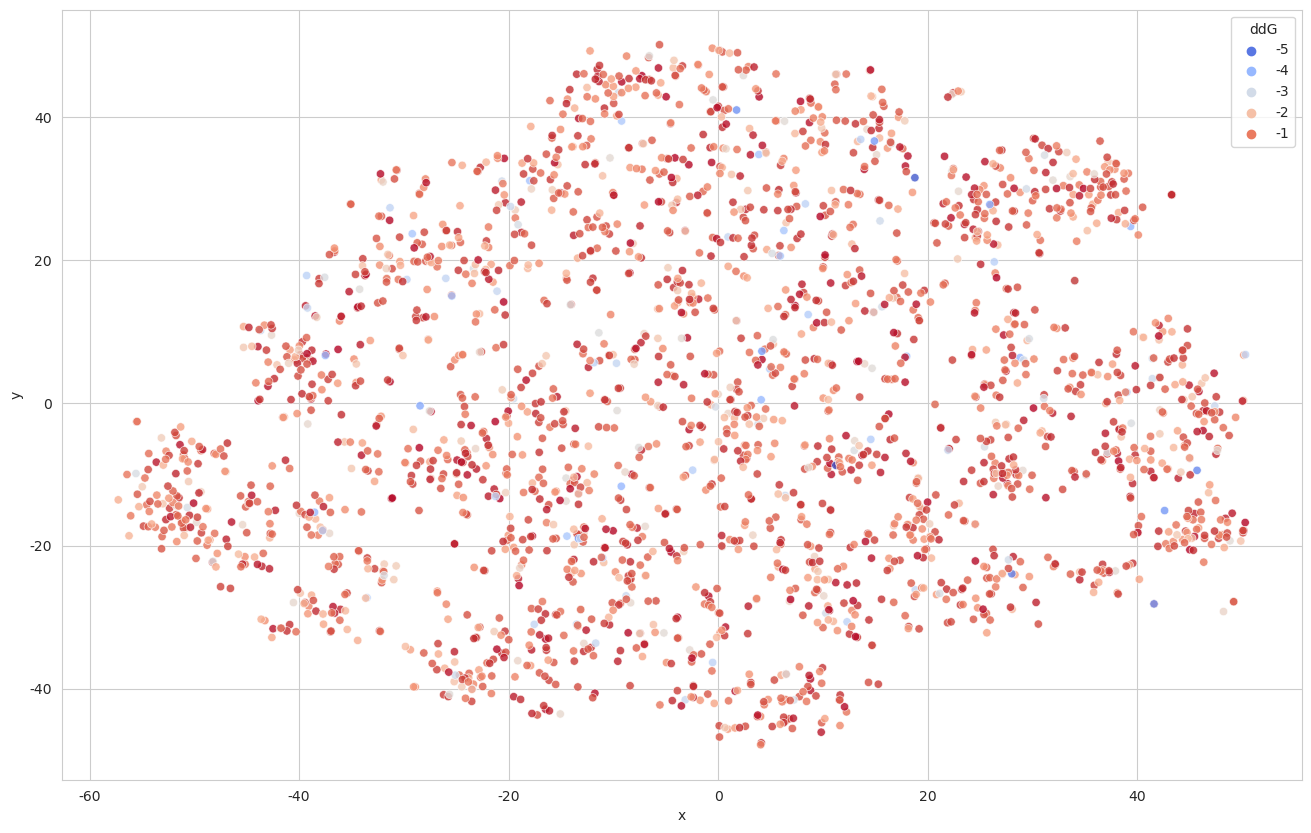

In [52]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm',
    data=z_tsne,
    alpha=0.8
)

CPU times: user 90.1 ms, sys: 8.16 ms, total: 98.3 ms
Wall time: 95.8 ms


<Axes: xlabel='x', ylabel='y'>

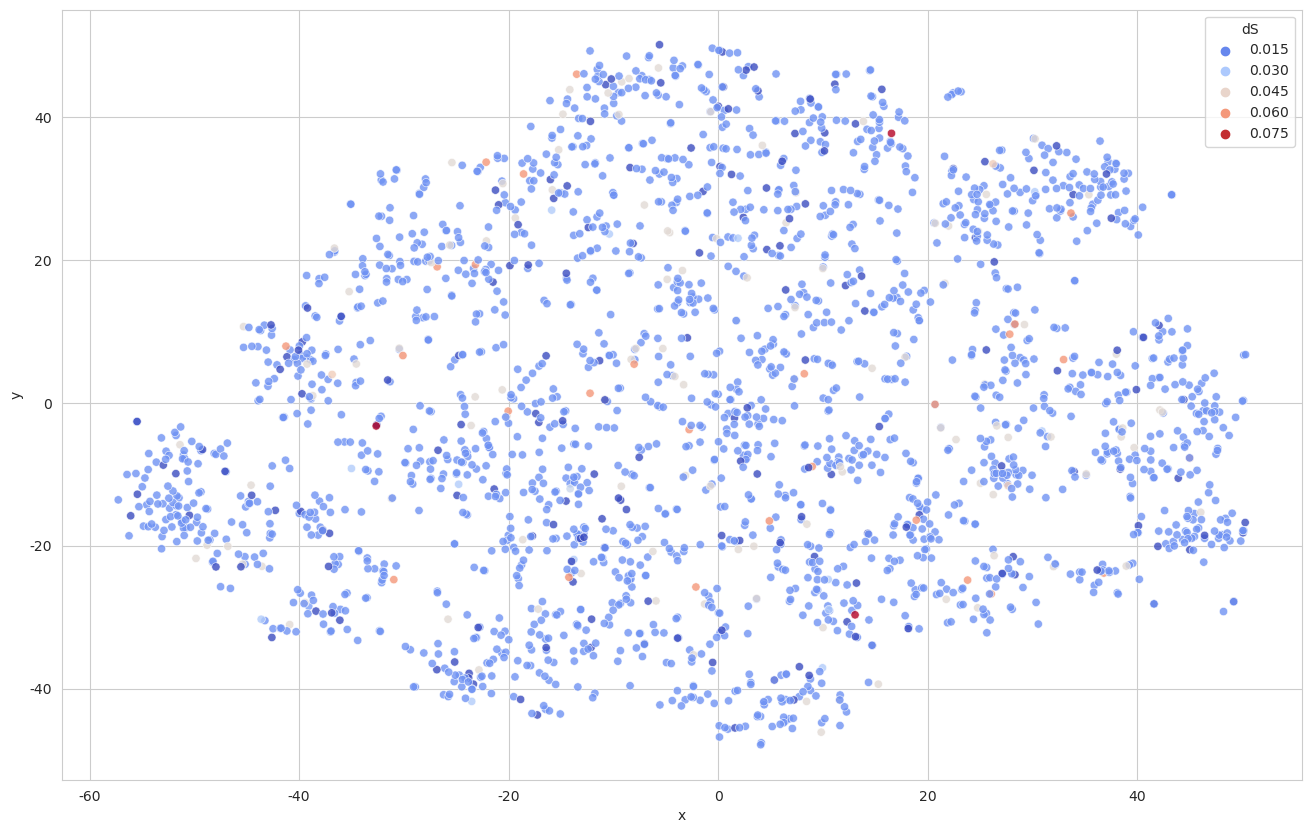

In [53]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="dS",
    palette='coolwarm',
    data=z_tsne,
    alpha=0.8
)

CPU times: user 85 ms, sys: 4.07 ms, total: 89.1 ms
Wall time: 87.2 ms


<Axes: xlabel='x', ylabel='y'>

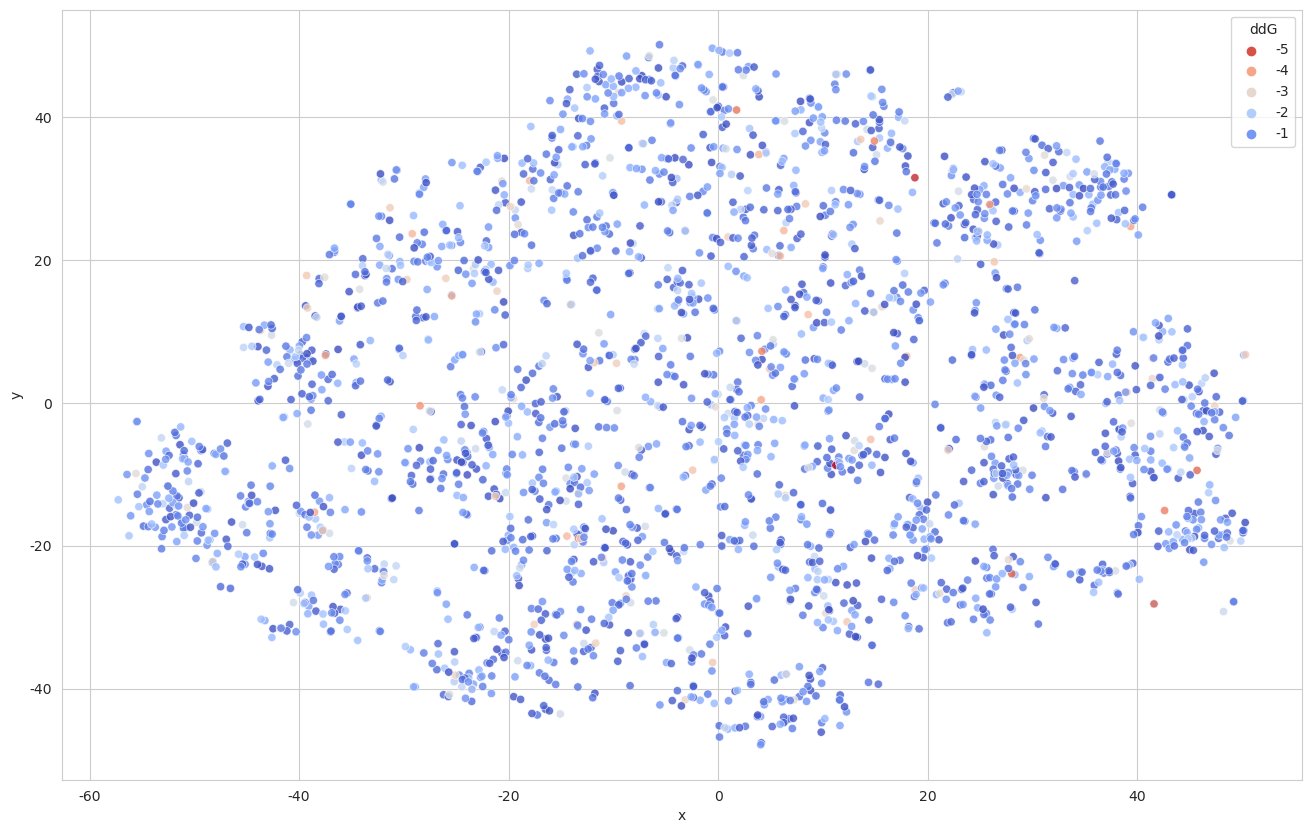

In [46]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[0 > z_tsne['ddG']][:3000],
    alpha=0.8
)

CPU times: user 71.3 ms, sys: 229 µs, total: 71.5 ms
Wall time: 70.3 ms


<Axes: xlabel='x', ylabel='y'>

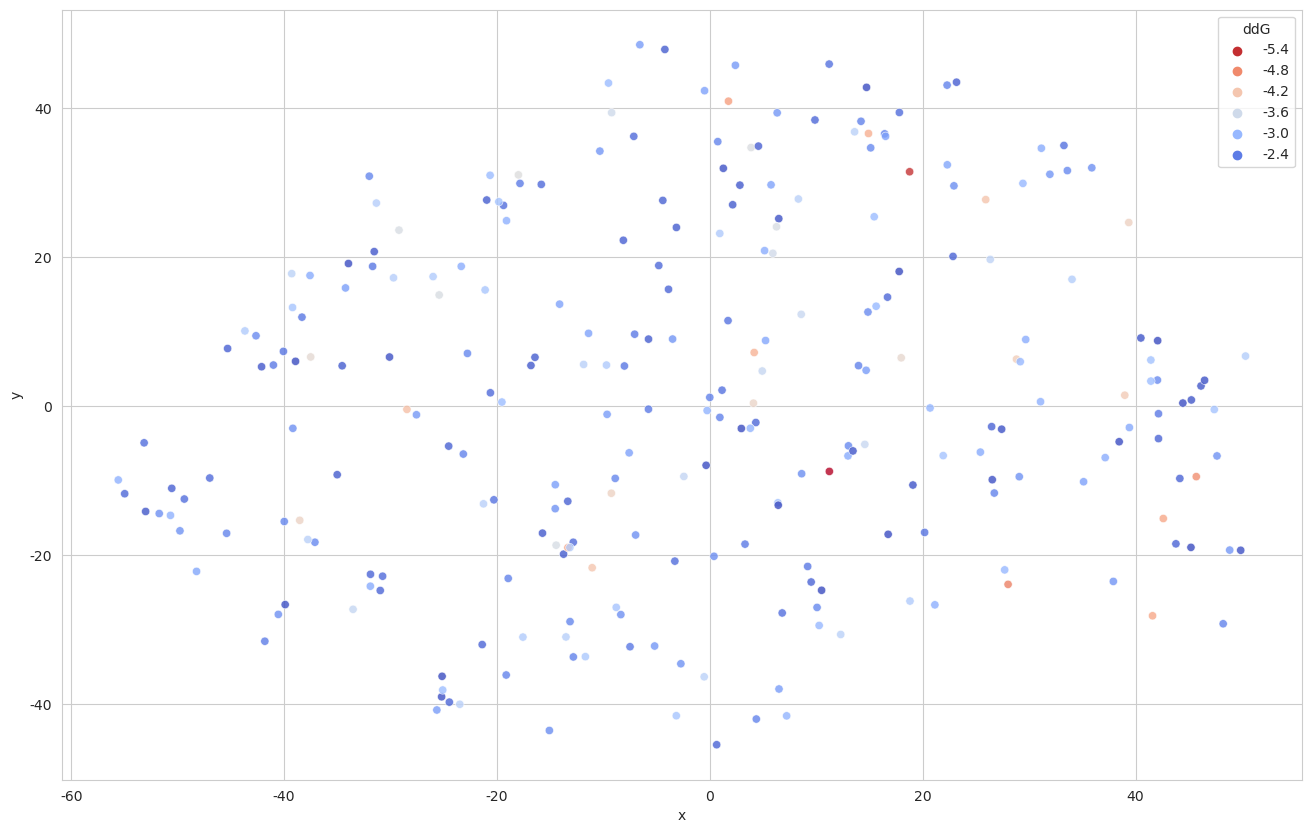

In [41]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[-2 > z_tsne['ddG']][:3000],
    alpha=0.8
)

CPU times: user 76.6 ms, sys: 32 µs, total: 76.6 ms
Wall time: 75.2 ms


<Axes: xlabel='x', ylabel='y'>

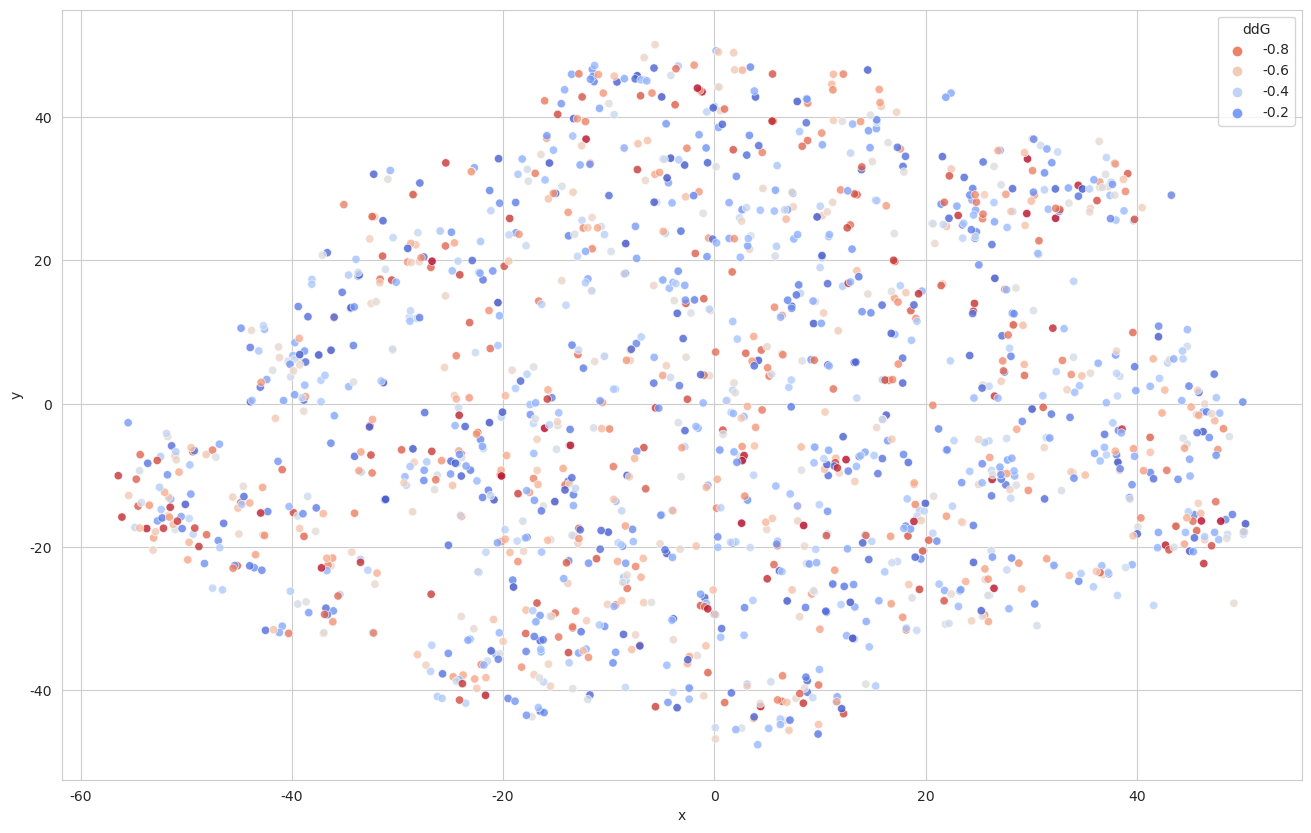

In [45]:
%%time
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="x", y="y",
    hue="ddG",
    palette='coolwarm_r',
    data=z_tsne[(1 > z_tsne['ddG']) & (-1 < z_tsne['ddG'])][:3000],
    alpha=0.8
)

In [43]:
z_norm = predict_z.norm(dim=1)
z_ddG = ddG
z_dS = dS

<Axes: xlabel='z_ddG', ylabel='z_dS'>

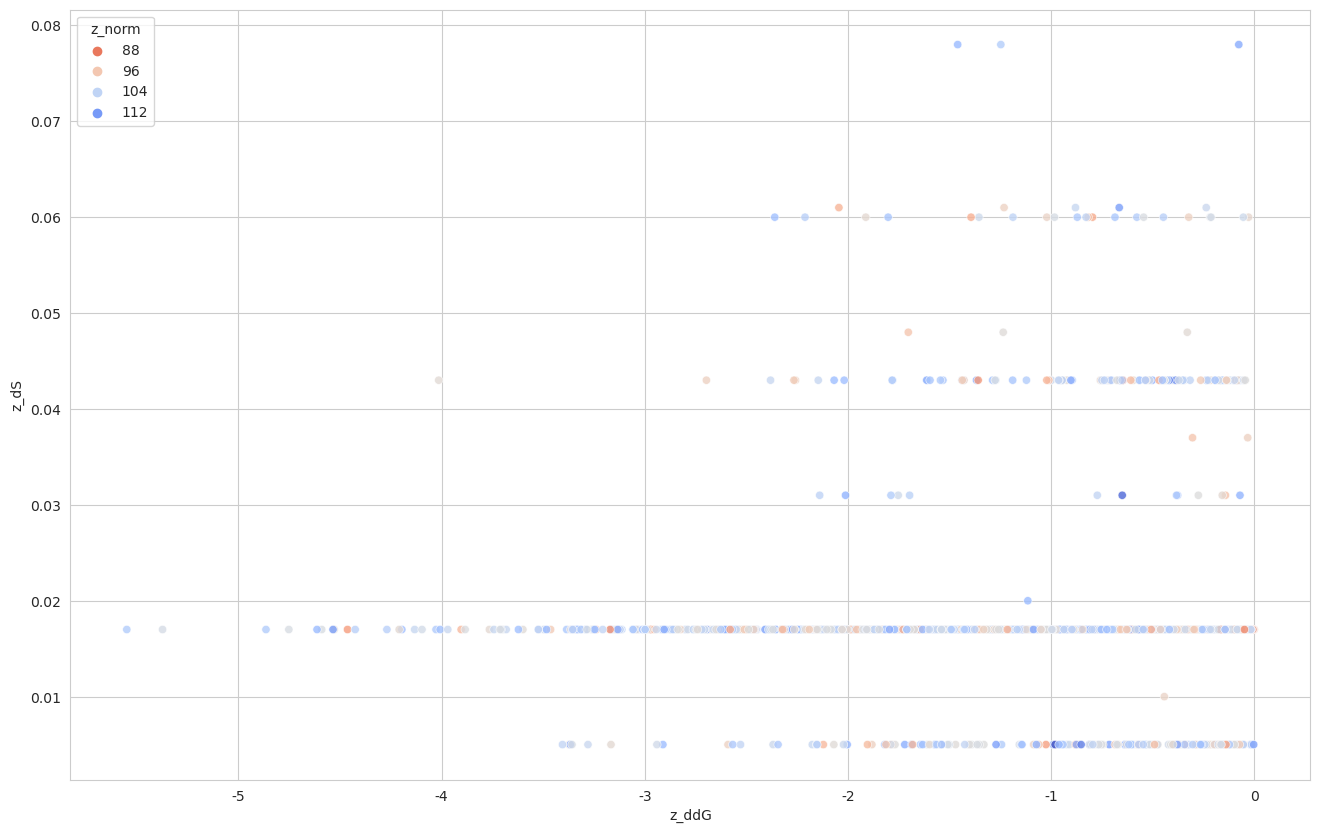

In [44]:
# 绘制z_norm与z_ddG和z_dS的关系
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="z_ddG",
    y="z_dS",
    hue="z_norm",
    palette='coolwarm_r',
    data=pd.DataFrame({'z_norm': z_norm, 'z_ddG': z_ddG, 'z_dS': z_dS}),
    alpha=0.8
)